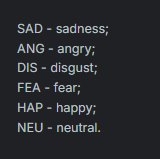

In [2]:
!pip install 

ERROR: You must give at least one requirement to install (see "pip help install")


In [62]:
import os
import re

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Audio
# from entropy import spectral_entropy
# from keras import layers
# from keras import models
# from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
# from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import itertools, torch

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

NameError: name 'sys' is not defined

In [4]:
# Paths to
Ravdess = "../input/speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24"
Crema = "../input/speech-emotion-recognition-en/Crema"
Savee = "../input/speech-emotion-recognition-en/Savee"
Tess = "../input/speech-emotion-recognition-en/Tess"
print(os.listdir(Ravdess))

['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21', 'Actor_01', 'Actor_11', 'Actor_20', 'Actor_08', 'Actor_15', 'Actor_06', 'Actor_12', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_04', 'Actor_19', 'Actor_10', 'Actor_09', 'Actor_14', 'Actor_03', 'Actor_13', 'Actor_18', 'Actor_07']


In [5]:
ravdess_directory_list = os.listdir(Ravdess)

emotion_df = []

for dir in ravdess_directory_list:
    actor = os.listdir(os.path.join(Ravdess, dir))
    for wav in actor:
        info = wav.partition(".wav")[0].split("-")
        emotion = int(info[2])
        emotion_df.append((emotion, os.path.join(Ravdess, dir, wav)))

In [6]:
Ravdess_df = pd.DataFrame.from_dict(emotion_df)
Ravdess_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

In [7]:
Ravdess_df.Emotion.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

/tmp/ipykernel_31/4248491501.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Ravdess_df.Emotion.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)


,Emotion,Path
0,surprise,../input/speech-emotion-recognition-en/Ravdess...
1,neutral,../input/speech-emotion-recognition-en/Ravdess...
2,disgust,../input/speech-emotion-recognition-en/Ravdess...
3,disgust,../input/speech-emotion-recognition-en/Ravdess...
4,neutral,../input/speech-emotion-recognition-en/Ravdess...


In [8]:
emotion_df = []

for wav in os.listdir(Crema):
    info = wav.partition(".wav")[0].split("_")
    if info[2] == 'SAD':
        emotion_df.append(("sad", Crema + "/" + wav))
    elif info[2] == 'ANG':
        emotion_df.append(("angry", Crema + "/" + wav))
    elif info[2] == 'DIS':
        emotion_df.append(("disgust", Crema + "/" + wav))
    elif info[2] == 'FEA':
        emotion_df.append(("fear", Crema + "/" + wav))
    elif info[2] == 'HAP':
        emotion_df.append(("happy", Crema + "/" + wav))
    elif info[2] == 'NEU':
        emotion_df.append(("neutral", Crema + "/" + wav))
    else:
        emotion_df.append(("unknown", Crema + "/" + wav))


Crema_df = pd.DataFrame.from_dict(emotion_df)
Crema_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Crema_df.head()

,Emotion,Path
0,disgust,../input/speech-emotion-recognition-en/Crema/1...
1,happy,../input/speech-emotion-recognition-en/Crema/1...
2,happy,../input/speech-emotion-recognition-en/Crema/1...
3,disgust,../input/speech-emotion-recognition-en/Crema/1...
4,disgust,../input/speech-emotion-recognition-en/Crema/1...


In [9]:
tess_directory_list = os.listdir(Tess)

emotion_df = []

for dir in tess_directory_list:
    for wav in os.listdir(os.path.join(Tess, dir)):
        info = wav.partition(".wav")[0].split("_")
        emo = info[2]
        if emo == "ps":
            emotion_df.append(("surprise", os.path.join(Tess, dir, wav)))
        else:
            emotion_df.append((emo, os.path.join(Tess, dir, wav)))


Tess_df = pd.DataFrame.from_dict(emotion_df)
Tess_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Tess_df.head()

,Emotion,Path
0,fear,../input/speech-emotion-recognition-en/Tess/YA...
1,fear,../input/speech-emotion-recognition-en/Tess/YA...
2,fear,../input/speech-emotion-recognition-en/Tess/YA...
3,fear,../input/speech-emotion-recognition-en/Tess/YA...
4,fear,../input/speech-emotion-recognition-en/Tess/YA...


In [10]:
savee_directiory_list = os.listdir(Savee)

emotion_df = []

for wav in savee_directiory_list:
    info = wav.partition(".wav")[0].split("_")[1].replace(r"[0-9]", "")
    emotion = re.split(r"[0-9]", info)[0]
    if emotion=='a':
        emotion_df.append(("angry", Savee + "/" + wav))
    elif emotion=='d':
        emotion_df.append(("disgust", Savee + "/" + wav))
    elif emotion=='f':
        emotion_df.append(("fear", Savee + "/" + wav))
    elif emotion=='h':
        emotion_df.append(("happy", Savee + "/" + wav))
    elif emotion=='n':
        emotion_df.append(("neutral", Savee + "/" + wav))
    elif emotion=='sa':
        emotion_df.append(("sad", Savee + "/" + wav))
    else:
        emotion_df.append(("surprise", Savee + "/" + wav))


Savee_df = pd.DataFrame.from_dict(emotion_df)
Savee_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Savee_df.head()

,Emotion,Path
0,happy,../input/speech-emotion-recognition-en/Savee/J...
1,fear,../input/speech-emotion-recognition-en/Savee/K...
2,happy,../input/speech-emotion-recognition-en/Savee/D...
3,disgust,../input/speech-emotion-recognition-en/Savee/D...
4,angry,../input/speech-emotion-recognition-en/Savee/K...


In [11]:
df = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis=0)
df.shape

(12162, 2)

In [12]:
%matplotlib inline

plt.style.use("ggplot")

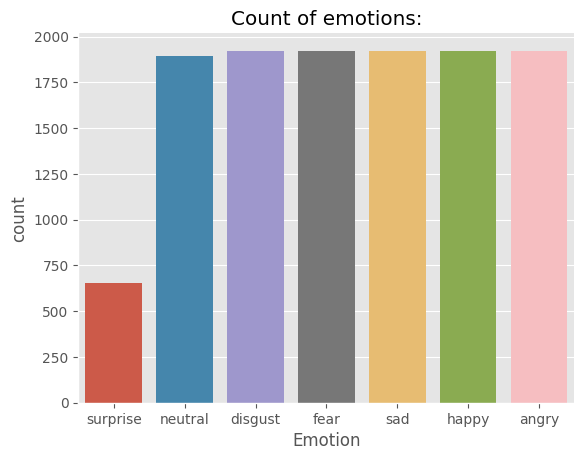

In [13]:
plt.title("Count of emotions:")
sns.countplot(x=df["Emotion"])
sns.despine(top=True, right=True, left=False, bottom=False)

In [14]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

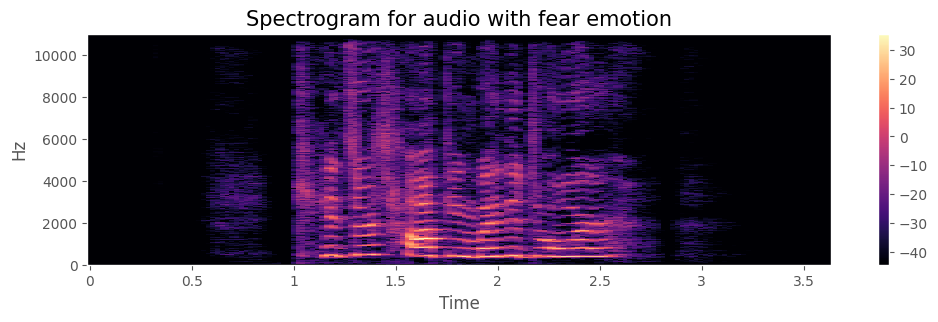

In [15]:
emotion='fear'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
# create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

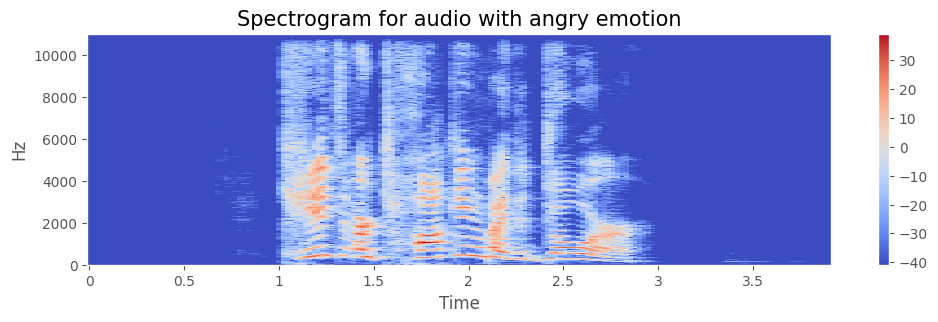

In [20]:
emotion='angry'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
# create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

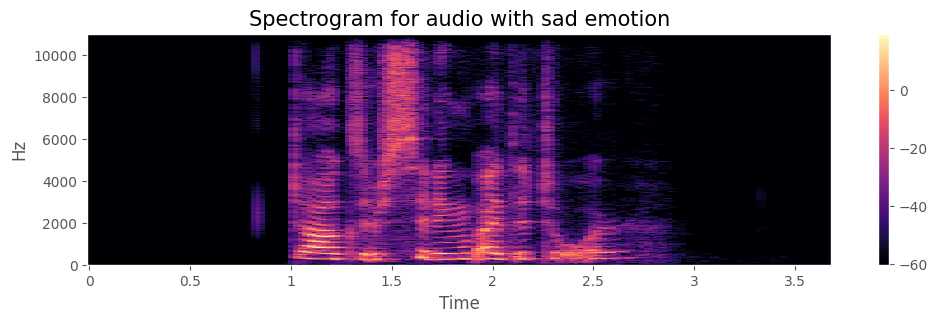

In [21]:
emotion='sad'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
# create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data augmentation

We have some ways for data augmentation in sound data:

1. Noise injection
2. Stretching
3. Shifting
4. Pitching

In [46]:
def noise(data, random=False, rate=0.035, threshold=0.075):
    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.
    Or use rate Random=False and rate for always adding fixed noise."""
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    """Stretching data with some rate."""
    return librosa.effects.time_stretch(data, rate)

def shift(data, rate=1000):
    """Shifting data with some rate"""
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7, random=False):
    """"Add some pitch to sound sample. Use random if you want to add random pitch with some threshold.
    Or use pitch_factor Random=False and rate for always adding fixed pitch."""
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

In [48]:
df.head()

,Emotion,Path
0,surprise,../input/speech-emotion-recognition-en/Ravdess...
1,neutral,../input/speech-emotion-recognition-en/Ravdess...
2,disgust,../input/speech-emotion-recognition-en/Ravdess...
3,disgust,../input/speech-emotion-recognition-en/Ravdess...
4,neutral,../input/speech-emotion-recognition-en/Ravdess...


In [ ]:
path = df[df["Emotion"] == "happy"]["Path"].iloc[0]
data, sampling_rate = librosa.load(path)

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(data, sampling_rate)
Audio(path)

In [ ]:
noised_data = noise(data, random=True)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=noised_data, sr=sampling_rate)
Audio(noised_data, rate=sampling_rate)


In [ ]:
stretched_data = stretch(data, rate=0.5)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=stretched_data, sr=sampling_rate)
Audio(stretched_data, rate=sampling_rate)


In [ ]:
shifted_data = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=shifted_data, sr=sampling_rate)
Audio(shifted_data, rate=sampling_rate)


In [ ]:
pitched_data = pitch(data, sampling_rate, pitch_factor=0.5, random=True)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=pitched_data, sr=sampling_rate)
Audio(pitched_data, rate=sampling_rate)

For our data augmentation we will use noise and pitch and combination with both of it.

## Feature extraction

#### There are some features may be useful:

1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy :The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
3. Spectral Centroid : The center of gravity of the spectrum.
4. Spectral Spread : The second central moment of the spectrum.
5. Spectral Entropy : Entropy of the normalized spectral energies for a set of sub-frames.
6. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
7. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
8. MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

In [36]:
n_fft = 2048
hop_length = 512

In [38]:
def chunks(data, frame_length, hop_length):
    for i in range(0, len(data), hop_length):
        yield data[i:i+frame_length]

# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)


def energy(data, frame_length=2048, hop_length=512):
    en = np.array([np.sum(np.power(np.abs(data[hop:hop+frame_length]), 2)) for hop in range(0, data.shape[0], hop_length)])
    return en / frame_length


def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)


def entropy_of_energy(data, frame_length=2048, hop_length=512):
    energies = energy(data, frame_length, hop_length)
    energies /= np.sum(energies)

    entropy = 0.0
    entropy -= energies * np.log2(energies)
    return entropy


def spc(data, sr, frame_length=2048, hop_length=512):
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spectral_centroid)


# def spc_entropy(data, sr):
#     spc_en = spectral_entropy(data, sf=sr, method="fft")
#     return spc_en

def spc_flux(data):
    isSpectrum = data.ndim == 1
    if isSpectrum:
        data = np.expand_dims(data, axis=1)

    X = np.c_[data[:, 0], data]
    af_Delta_X = np.diff(X, 1, axis=1)
    vsf = np.sqrt((np.power(af_Delta_X, 2).sum(axis=0))) / X.shape[0]

    return np.squeeze(vsf) if isSpectrum else vsf


def spc_rollof(data, sr, frame_length=2048, hop_length=512):
    spcrollof = librosa.feature.spectral_rolloff(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spcrollof)


def chroma_stft(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    stft = np.abs(librosa.stft(data))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
    return np.squeeze(chroma_stft.T) if not flatten else np.ravel(chroma_stft.T)


def mel_spc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    return np.squeeze(mel.T) if not flatten else np.ravel(mel.T)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

In [39]:
path = np.array(df["Path"])[658]
data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
len(data)

55125

In [40]:
print("ZCR: ", zcr(data).shape)
print("Energy: ", energy(data).shape)
print("Entropy of Energy :", entropy_of_energy(data).shape)
print("RMS :", rmse(data).shape)
print("Spectral Centroid :", spc(data, sampling_rate).shape)
# print("Spectral Entropy: ", spc_entropy(data, sampling_rate).shape)
print("Spectral Flux: ", spc_flux(data).shape)
print("Spectral Rollof: ", spc_rollof(data, sampling_rate).shape)
print("Chroma STFT: ", chroma_stft(data, sampling_rate).shape)
print("MelSpectrogram: ", mel_spc(data, sampling_rate).shape)
print("MFCC: ", mfcc(data, sampling_rate).shape)


ZCR:  (108,)
Energy:  (108,)
Entropy of Energy : (108,)
RMS : (108,)
Spectral Centroid : (108,)
Spectral Flux:  ()
Spectral Rollof:  (108,)
Chroma STFT:  (1296,)
MelSpectrogram:  (13824,)
MFCC:  (2160,)


In [41]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        # np.mean(energy(data, frame_length, hop_length),axis=0),
                        # np.mean(entropy_of_energy(data, frame_length, hop_length), axis=0),
                        rmse(data, frame_length, hop_length),
                        # spc(data, sr, frame_length, hop_length),
                        # spc_entropy(data, sr),
                        # spc_flux(data),
                        # spc_rollof(data, sr, frame_length, hop_length),
                        # chroma_stft(data, sr, frame_length, hop_length),
                        # mel_spc(data, sr, frame_length, hop_length, flatten=True)
                        # mfcc(data, sr, frame_length, hop_length)
                                    ))
    return result

In [42]:
def get_features(path, duration=2.5, offset=0.6):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=duration, offset=offset)

     # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data, random=True)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with pitching
    pitched_data = pitch(data, sample_rate, random=True)
    res3 = extract_features(pitched_data, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    # data with pitching and white_noise
    new_data = pitch(data, sample_rate, random=True)
    data_noise_pitch = noise(new_data, random=True)
    res3 = extract_features(data_noise_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result


In [47]:
X, Y = [], []
print("Feature processing...")
for path, emotion, ind in zip(df.Path, df.Emotion, range(df.Path.shape[0])):
    features = get_features(path)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
print("Done.")

Feature processing...
0 samples has been processed...
100 samples has been processed...
200 samples has been processed...
300 samples has been processed...
400 samples has been processed...
500 samples has been processed...
600 samples has been processed...
700 samples has been processed...
800 samples has been processed...
900 samples has been processed...
1000 samples has been processed...
1100 samples has been processed...
1200 samples has been processed...
1300 samples has been processed...
1400 samples has been processed...
1500 samples has been processed...
1600 samples has been processed...
1700 samples has been processed...
1800 samples has been processed...
1900 samples has been processed...
2000 samples has been processed...
2100 samples has been processed...
2200 samples has been processed...
2300 samples has been processed...
2400 samples has been processed...
2500 samples has been processed...
2600 samples has been processed...
2700 samples has been processed...
2800 sampl

Let's save our features as DataFrame for further processing:

In [55]:
features_path = "./features.csv"

In [56]:
extracted_df = pd.DataFrame(X)
extracted_df["labels"] = Y
extracted_df.to_csv(features_path, index=False)
extracted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,labels
0,0.343750,0.479492,0.573730,0.458008,0.375488,0.301758,0.269043,0.255371,0.251465,0.251953,...,-1.517691,-1.716481,-1.599312,-1.234615,-0.693200,-0.038981,0.675205,1.405603,2.112302,surprise
1,0.248535,0.376465,0.493652,0.478516,0.480957,0.471680,0.477051,0.494141,0.484375,0.498047,...,0.675753,-1.288656,-3.715772,0.719854,1.587222,1.000465,0.483993,0.862940,-0.052613,surprise
2,0.312500,0.441895,0.542969,0.471191,0.383789,0.321289,0.282227,0.262695,0.254883,0.250488,...,-0.785562,0.518777,1.858219,2.983571,3.728808,4.038086,3.967036,3.656072,3.282322,surprise
3,0.250000,0.379395,0.512207,0.521973,0.503418,0.497070,0.481934,0.467773,0.479980,0.467773,...,-3.133852,0.382135,-0.436413,0.824477,3.332816,-1.218071,-0.841910,-0.802392,-1.004774,surprise
4,0.437500,0.659668,0.862305,0.878906,0.865234,0.847168,0.845703,0.827637,0.835938,0.667969,...,2.586420,2.746858,2.223281,0.986924,-0.730691,-2.530884,-4.002835,-4.849377,-4.929749,neutral


In [57]:
extracted_df = pd.read_csv(features_path)
print(extracted_df.shape)

(48648, 2377)


In [52]:
# Fill NaN with 0
extracted_df = extracted_df.fillna(0)
print(extracted_df.isna().any())
extracted_df.shape


0         False
1         False
2         False
3         False
4         False
          ...  
2372      False
2373      False
2374      False
2375      False
labels    False
Length: 2377, dtype: bool


(48648, 2377)

In [53]:
extracted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,labels
0,0.343750,0.479492,0.573730,0.458008,0.375488,0.301758,0.269043,0.255371,0.251465,0.251953,...,-1.517691,-1.716481,-1.599312,-1.234615,-0.693200,-0.038981,0.675205,1.405603,2.112302,surprise
1,0.248535,0.376465,0.493652,0.478516,0.480957,0.471680,0.477051,0.494141,0.484375,0.498047,...,0.675753,-1.288656,-3.715772,0.719854,1.587222,1.000465,0.483993,0.862940,-0.052613,surprise
2,0.312500,0.441895,0.542969,0.471191,0.383789,0.321289,0.282227,0.262695,0.254883,0.250488,...,-0.785562,0.518777,1.858219,2.983571,3.728808,4.038086,3.967036,3.656072,3.282322,surprise
3,0.250000,0.379395,0.512207,0.521973,0.503418,0.497070,0.481934,0.467773,0.479980,0.467773,...,-3.133852,0.382135,-0.436413,0.824477,3.332816,-1.218071,-0.841910,-0.802392,-1.004774,surprise
4,0.437500,0.659668,0.862305,0.878906,0.865234,0.847168,0.845703,0.827637,0.835938,0.667969,...,2.586420,2.746858,2.223281,0.986924,-0.730691,-2.530884,-4.002835,-4.849377,-4.929749,neutral


## Data preparation

As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [58]:
X = extracted_df.drop(labels="labels", axis=1)
Y = extracted_df["labels"]

In [63]:
lb = LabelEncoder()
Y_encoded = lb.fit_transform(Y)

Y_tensor = torch.tensor(Y_encoded)
Y_onehot = torch.nn.functional.one_hot(Y_tensor)

Y_onehot = Y_onehot.float()

print(lb.classes_) 
print(Y_onehot)

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((38918, 2376), (9730, 2376), (38918,), (9730,))

In [65]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1, shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((35026, 2376), (9730, 2376), (3892, 2376), (35026,), (9730,), (3892,))

In [66]:
# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((35026, 2376), (9730, 2376), (3892, 2376), (35026,), (9730,), (3892,))

In [67]:
# We have to use 1-dimensional CNN which need specifical shape:
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(35026, 2376, 1)

# Model